# DSA4212 Assignment 1: Data Augmentation Strategy on baseline with batch size = 1


In [1]:
import numpy as np
## Progress bar
from tqdm.auto import tqdm
import pylab as plt
import copy
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
import flax
from flax import linen as nn
import jax
import jax.numpy as jnp
from typing import Any, Sequence
import optax

In [2]:
if 'google.colab' in str(get_ipython()):
  print("All ok -- code is running on a Google Colab")
else:
    print("==="*15, " WARNING ","==="*15)
    print("For DSA4212 assignment 1, code needs to be run on a Google Colab with a single GPU")
    print("==="*15, " WARNING ","==="*15)

All ok -- code is running on a Google Colab


In [3]:
!nvidia-smi -L
!lscpu |grep 'Model name'
!free -h --si | awk  '/Mem:/{print $2}'

GPU 0: Tesla T4 (UUID: GPU-39efb9d3-0079-5794-1c0e-ba913a8ab6bc)
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
12G


# Connect to Google Drive & Load data

In [4]:
# mount the Google Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%pwd

'/content'

In [6]:
# goto to data folder -- you may need to change this location
%cd /content/drive/MyDrive/dataset/DSA4212/assignment_1/

/content/drive/MyDrive/dataset/DSA4212/assignment_1


In [7]:
class_names=["fish", "dog", "device", "chainsaw", "church", "horn", "truck", "petrol", "golf", "parachute"]

# load data -- be patient, does take a few secs
data_train = np.load("assignment_1_train.npz")
data_val = np.load("assignment_1_val.npz")

X_train = data_train["img"].astype(np.float32) / 255.   # set pixel intensities to [0,1]
X_val = data_val["img"].astype(np.float32) / 255.
Y_train = data_train["label"].astype(int)
Y_val = data_val["label"].astype(int)

_,H,W,C = X_train.shape
print(f"Img Shape: {H}x{W}x{C}")

Img Shape: 128x128x3


In [8]:
# shuffle the train set
indices_shuffled = np.arange(len(X_train))
np.random.shuffle(indices_shuffled)
X_train = X_train[indices_shuffled]
Y_train = Y_train[indices_shuffled]

# shuffle the validation set
indices_shuffled = np.arange(len(X_val))
np.random.shuffle(indices_shuffled)
X_val = X_val[indices_shuffled]
Y_val = Y_val[indices_shuffled]

In [9]:
# Data Augmentation for training set

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

augmented_X = []
num_augmented = 0
for X_batch, y_batch in datagen.flow(X_train, Y_train, batch_size=1, shuffle=False):
    augmented_X.append(X_batch)
    num_augmented += 1
    if num_augmented == X_train.shape[0]:
        break

augmented_trainX = np.concatenate(augmented_X)

In [10]:
# put data to GPU
# X_train = jax.device_put(X_train)
X_val = jax.device_put(X_val)
X_train = jax.device_put(augmented_trainX)

In [11]:
sz_train = X_train.size * X_train.itemsize / 2.**30
sz_val = X_val.size * X_train.itemsize / 2.**30

print(f"Training Set Size: {sz_train:2.2f} Go")
print(f"Validaton Set Size: {sz_val:2.2f} Go")

Training Set Size: 1.70 Go
Validaton Set Size: 0.71 Go


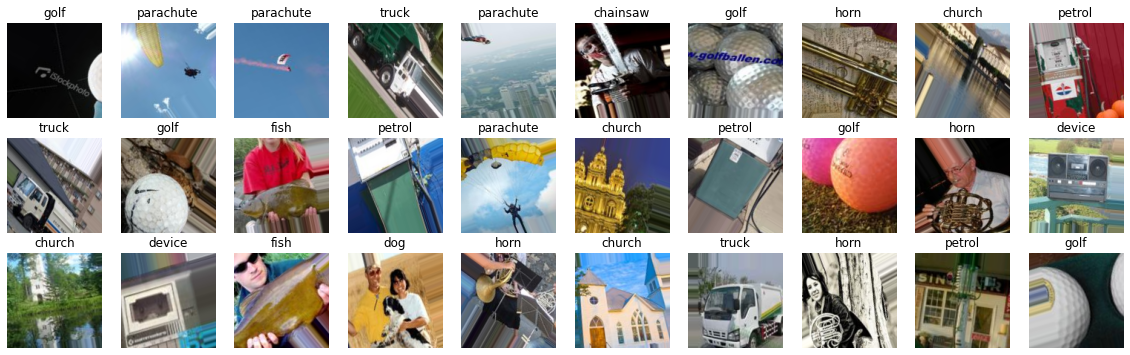

In [12]:
# train set:: sanity check
# plt a few random images in the trainset as well as their label
plt.figure( figsize=(10*2,3*2) )
for k in range(3*10):
    index = np.random.randint(low=0, high=len(X_train))
    plt.subplot(3,10,k+1)
    plt.axis("off")
    plt.imshow(X_train[index,:,:,:])
    plt.title(class_names[Y_train[index]])

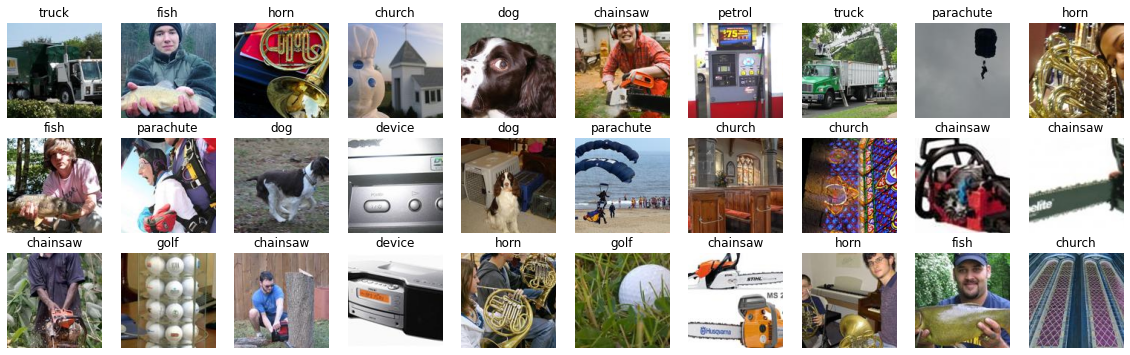

In [13]:
# validation set:: sanity check
# plt a few images as well as their label
plt.figure( figsize=(10*2,3*2) )
for k in range(3*10):
    index = np.random.randint(low=0, high=len(X_val))
    plt.subplot(3,10,k+1)
    plt.axis("off")
    plt.imshow(X_val[index,:,:,:])
    plt.title(class_names[Y_val[index]])

In [14]:
class LayerNorm(nn.Module):
    """
    input:
    ======
     x: tensor with D channels of dimension (B,H,W,D)
     
    output:
    ======
     x_normalized: tensor with D channels of dimension (B,H,W,D)
     
     
    Description:
    ===========
    for each each element `i` and each dimension `d`,
    normalize the 2D array x[i,:,:,d] by substracting its mean and divide by its standard deviation
       x_normalized[i,:,:,d] = (x[i,:,:,d] - mean) / stdev
    """
    @nn.compact
    def __call__(self, inputs):
        eps = 10**-3
        mean = jnp.expand_dims(jnp.mean(inputs, axis=(1,2)), axis=(1,2))
        std = jnp.expand_dims(jnp.std(inputs, axis=(1,2)), axis=(1,2))
        return (inputs - mean) / (eps + std)

class SimpleCNN(nn.Module):
    """ a simple convolutional neural network """
    n_filters: Sequence[int]  # sequence -- number of CNN filters in each layer
    n_class: int              # number of possible classes
    
    @nn.compact
    def __call__(self, x):
        """
        inputs:
        ======
         inputs: batch of images of dimension (X,H,W,3)

        outputs:
        ======
         probas: predictive probability vector
        """
        
        # convolutional layers + normalization
        for i, feat_dim in enumerate(self.n_filters):
            x = LayerNorm()(x)
            x = nn.elu( nn.Conv(features=feat_dim, kernel_size=(3,3), strides = 2, padding='SAME', name=f'layers_{i}_1')(x) )
            
        # pooling -- average across the dimension (1,2)
        x =  x.mean(axis=(1,2))
        
        # last dense layer
        x = nn.Dense(self.n_class)(x)
        
        #convert to proba
        probas = nn.softmax(x)
        return probas

In [15]:
# generate a random generator "key" that is used to initialize the net parameters
key = jax.random.PRNGKey(0)
net = SimpleCNN(n_filters=[32,64, 128], n_class = 10)

# to initialize the network, one needs to propagate some data through it
# and provide with a RNG key
key, key_ = jax.random.split(key)
batch_size = 32
batch_of_images = X_train[:batch_size,:,:,:]
params_init = net.init(key_, batch_of_images)

# count the number of parameters
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params_init))
print(f"Number of Neural Parameters: {param_count//1000}k")

Number of Neural Parameters: 94k


In [16]:
@jax.jit
def loss(params, x, y):
  """ cross-entropy loss
  inputs:
  ======
   params: neural network weights
   x: (B,H,W,3) -- batch of images
   y: (B) -- labels
  """
  n_class = 10

  # compute Cross-Entropy
  pred = net.apply(params, x)
  y_hot = jax.nn.one_hot(y, n_class)
  CEs = -jnp.sum(y_hot * jnp.log(pred), axis=1)
  return jnp.mean(CEs)

# generate the gradient function
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) )

In [17]:
@jax.jit
def prediction_class(params, x):
  """ make a prediction """
  pred = net.apply(params, x)
  pred_class = jnp.argmax(pred, axis=1)
  return pred_class

@jax.jit
def accuracy(params, x, y):
  """
  compute the accuracy on a batch of images

  inputs:
  ======
   params: neural network weights
   x: (B,H,W,3) -- batch of images
   y: (B) -- labels
  """
  n_class = 10

  # compute Cross-Entropy
  pred_class = prediction_class(params, x)
  return jnp.mean(pred_class == y)

# generate the gradient function
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) )

In [18]:
# let us randomize the weights again to start from scratch
params = copy.deepcopy(params_init)

#define the ADAM optimizer
optimizer = optax.adam(learning_rate=0.01, eps=0.001)

#generate the initial state of the optimizer
opt_state = optimizer.init(params)

In [19]:
niter = 1000
batch_size = 512

# save the train loss
loss_train_history = []
loss_train_history_time = []

# save the validation loss
loss_val_history = []
loss_val_history_time = []

# save accuracies
accuracies_history = []
accuracies_history_time = []

time_start = time.time()
for k in tqdm( range(niter) ):
  # create a batch
  indices = jnp.arange(k*batch_size, (k+1)*batch_size) % len(X_train)
  X_batch = X_train[indices]
  Y_batch = Y_train[indices]

  # compute loss and gradients
  loss_train, grads = loss_value_and_grad(params, X_batch, Y_batch)
  time_elapsed = time.time() - time_start

  if k % 50 == 0:
    # compute the accuracy on a batch only (to save a bit of time)
    N = 512
    acc_val = 100*accuracy(params, X_val[:N], Y_val[:N])
    acc_train = 100*accuracy(params, X_train[:N], Y_train[:N])
    nb_epoch = float(k+1)*batch_size / len(X_train)
    accuracies_history.append([acc_train, acc_val])
    accuracies_history_time.append(time_elapsed)

    # also compute test loss
    loss_val = loss(params, X_val[:N], Y_val[:N])
    loss_val_history.append( loss_val )
    loss_val_history_time.append( time_elapsed )

    print(f"Time:{time_elapsed:3.1f}sec \t Epoch:{nb_epoch:2.1f} \t Loss [{loss_train:2.2f} / {loss_val:2.2f}] \t Accuracy Train/Valid: [{acc_train:2.2f}% / {acc_val:2.2f}%]")

  # generate the "update mechanism" and update the state of the optimizer
  updates, opt_state = optimizer.update(grads, opt_state, params)
  # apply the "update mechanism"
  params = optax.apply_updates(params, updates)

  #opt_state, params = do_update(grads, opt_state, params)
    
  # save the loss
  loss_train_history_time.append( time_elapsed )
  loss_train_history.append( loss_train.item() )

  0%|          | 0/1000 [00:00<?, ?it/s]

Time:7.5sec 	 Epoch:0.1 	 Loss [2.31 / 2.30] 	 Accuracy Train/Valid: [10.94% / 11.52%]
Time:19.2sec 	 Epoch:2.8 	 Loss [1.73 / 1.78] 	 Accuracy Train/Valid: [38.28% / 38.09%]
Time:24.1sec 	 Epoch:5.6 	 Loss [1.46 / 1.45] 	 Accuracy Train/Valid: [53.32% / 50.59%]
Time:29.5sec 	 Epoch:8.3 	 Loss [1.33 / 1.39] 	 Accuracy Train/Valid: [54.69% / 55.08%]
Time:34.6sec 	 Epoch:11.1 	 Loss [1.29 / 1.29] 	 Accuracy Train/Valid: [56.64% / 59.57%]
Time:39.9sec 	 Epoch:13.8 	 Loss [1.25 / 1.29] 	 Accuracy Train/Valid: [66.21% / 60.35%]
Time:45.1sec 	 Epoch:16.6 	 Loss [1.06 / 1.15] 	 Accuracy Train/Valid: [66.21% / 62.70%]
Time:50.4sec 	 Epoch:19.3 	 Loss [0.99 / 1.12] 	 Accuracy Train/Valid: [69.34% / 64.84%]
Time:55.9sec 	 Epoch:22.1 	 Loss [1.01 / 1.08] 	 Accuracy Train/Valid: [67.38% / 65.82%]
Time:61.1sec 	 Epoch:24.8 	 Loss [1.02 / 1.14] 	 Accuracy Train/Valid: [66.60% / 63.87%]
Time:66.6sec 	 Epoch:27.6 	 Loss [0.84 / 1.08] 	 Accuracy Train/Valid: [73.44% / 64.65%]
Time:71.9sec 	 Epoch:30.3 

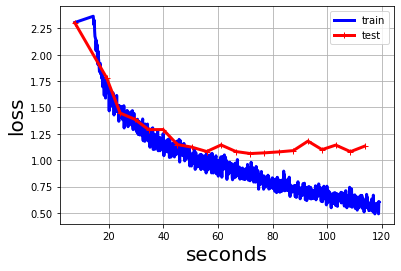

In [20]:
plt.plot(loss_train_history_time, loss_train_history, "b-", lw = 3, label="train")
plt.plot(loss_val_history_time, loss_val_history, "r-+", lw = 3, label="test")
plt.xlabel("seconds", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.grid(True)
plt.legend()


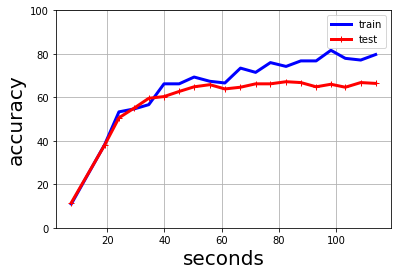

In [21]:
accuracies_history = np.array(accuracies_history)
plt.plot(accuracies_history_time, accuracies_history[:,0], "b-", lw = 3, label="train")
plt.plot(accuracies_history_time, accuracies_history[:,1], "r-+", lw = 3, label="test")
plt.xlabel("seconds", fontsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.ylim(0,100)
plt.grid(True)
plt.legend()

In [22]:
# final validation accuracy
pred_val = []
n_forward_pass = len(X_val) // batch_size
for k in tqdm(range(n_forward_pass)):
  pred_val.append( prediction_class(params, X_val[k*batch_size:(k+1)*batch_size]) )
pred_val.append( prediction_class(params, X_val[n_forward_pass*batch_size:]) )

pred_val = np.concatenate(pred_val)
acc_validation = 100*jnp.mean(pred_val == Y_val)
print( f"Final Validation Accuracy: {acc_validation:2.1f}%")

  0%|          | 0/7 [00:00<?, ?it/s]

Final Validation Accuracy: 64.4%
